### Tutorial preparation
Multi-body support was added to `qci-client` in version 3.2.0, but in order to utilize this tutorial, a version of `qci-client` of at least 4.0 is required.

In [1]:
!pip install "qci-client>=4.0"
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import qci_client as qc

# Multi-body Tutorial
Multi-body problems are polynomials where the total degree of at least one term in the polynomial is higher than 2. For instance 
$$
f(x,y)=xy^2-x^2y+x+y
$$ 
is a two variable, cubic problem.

## Optimization

Dirac-3 is a purpose-built device for finding global minima of a polynomial function. As demonstrated in the [Dirac-3 Quick Start](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/dirac-3-quick-start), it optimizes a multi-variate polynomial over a domain $x_i\in[0,R]\, i\in[0,1,\ldots,N-1]$ where $R$ is a positive value all $x_i$ must sum to.

## Example
Observe the following visualization of the function. The surface with the jet color scale describes the function across the entire domain $0\leq x\leq 10, 0\leq y\leq 10$, while the surface in semi transparent blue shows the domain of the optimization problem with the sum constraint of $x+y=10$. Notice the cross section with two extrema due to the cubic curvature indicates the function range Dirac-3 samples.

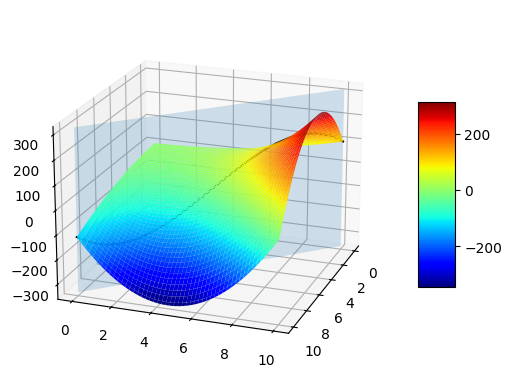

In [2]:
X = np.linspace(0, 10, 100)
Y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(X, Y)
Z = X*Y**2 - X**2*Y - X*X - 2*X +Y*Y
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surface = ax.plot_surface(X, Y, Z, cmap=cm.jet)

# Add a color bar which maps values to colors.
fig.colorbar(surface, shrink=0.5, aspect=5)
X2 = np.linspace(0, 10, 20)
Y2 = 10 - X2
Z2 = X2 * Y2 ** 2 - X2 ** 2 * Y2 - X2 ** 2 - 2 * X2 + Y2 ** 2
ax.plot3D(X2, Y2, Z2, "k-")
X3 = X2 * np.ones((20, 20))
Y3 = 10 - X3
Z3 = np.linspace(np.min(Z), np.max(Z), 20) * np.ones((20, 20))
sum_surface = ax.plot_surface(X3, Y3, Z3.T, alpha=0.2)
ax.view_init(azim=20, elev=20)


## Running the Problem
We will prepare data in a list and a list of lists, upload the polynomial file to Qatalyst and submit a job.

### QciClient Instantiation
This call to `QciClient` uses the environment variables `QCI_TOKEN` and `QCI_API_URL` to configure the API connection. It may also be called with `api_token` and `url` parameters to configure it explicitly. See the [Quick Start on Cloud](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/quick-start-on-cloud) tutorial for a deeper explanation on this configuration.


In [3]:
client = qc.QciClient()

### Polynomial Format
The ability to support higher order terms efficiently for the majority of problems requires a sparse format. That format is inspired by polynomials themselves. Two different arrays are required. The first is a coefficient array. Each term in the function has an entry in the coefficient array. The second array, the indices array, is where to indicate which term the corresponding coefficient is for. The second polynomial from above is presented here.

$$
f(x,y)=xy^2-x^2y+x+y
$$ 
is represented in polynomial format
```
poly_coefficients = [1, -1, 1, 1]
poly_indices = [[1, 2, 2], [1, 1, 2], [0, 0, 1], [0, 0, 2]]
```


In [4]:
poly_coefficients = [1, -1, 1, 1]
poly_indices = [[1, 2, 2], [1, 1, 2], [0, 0, 1], [0, 0, 2]]
data = []
for i in range(len(poly_coefficients)):
    data.append({
        "val": poly_coefficients[i],
        "idx": poly_indices[i]
    })
poly_file = {"file_name": "test-polynomial",
             "file_config": {"polynomial": {
                 "min_degree": 1,
                 "max_degree": 3,
                 "num_variables": 2,
                 "data": data
             }}}
file_id = client.upload_file(file=poly_file)["file_id"]
file_id

'6671f7df98263204a365dd57'

In [5]:
poly_file

{'file_name': 'test-polynomial',
 'file_config': {'polynomial': {'min_degree': 1,
   'max_degree': 3,
   'num_variables': 2,
   'data': [{'val': 1, 'idx': [1, 2, 2]},
    {'val': -1, 'idx': [1, 1, 2]},
    {'val': 1, 'idx': [0, 0, 1]},
    {'val': 1, 'idx': [0, 0, 2]}]}}}

In [6]:
job_body = client.build_job_body(job_type="sample-hamiltonian", polynomial_file_id=file_id, job_params={"device_type": "dirac-3", "sum_constraint": 10, "solution_precision": 1, "relaxation_schedule": 1, "num_samples": 15})
job_body

{'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '6671f7df98263204a365dd57'}},
  'device_config': {'dirac-3': {'num_samples': 15,
    'relaxation_schedule': 1,
    'solution_precision': 1,
    'sum_constraint': 10}}}}

In [7]:
response = client.process_job(job_body=job_body)

2024-06-18 15:10:55 - Dirac allocation balance = 0 s (unmetered)
2024-06-18 15:10:55 - Job submitted: job_id='6671f7dfa3e6a645a5c4e7ac'
2024-06-18 15:10:55 - QUEUED
2024-06-18 15:10:58 - RUNNING
2024-06-18 15:11:19 - COMPLETED
2024-06-18 15:11:21 - Dirac allocation balance = 0 s (unmetered)


In [8]:
response

{'job_info': {'job_id': '6671f7dfa3e6a645a5c4e7ac',
  'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '6671f7df98263204a365dd57'}},
   'device_config': {'dirac-3': {'num_samples': 15,
     'relaxation_schedule': 1,
     'solution_precision': 1,
     'sum_constraint': 10}}},
  'job_status': {'submitted_at_rfc3339nano': '2024-06-18T21:10:55.815Z',
   'queued_at_rfc3339nano': '2024-06-18T21:10:55.815Z',
   'running_at_rfc3339nano': '2024-06-18T21:10:56.571Z',
   'completed_at_rfc3339nano': '2024-06-18T21:11:18.655Z'},
  'job_result': {'file_id': '6671f7f698263204a365dd59', 'device_usage_s': 20}},
 'status': 'COMPLETED',
 'results': {'counts': [3, 2, 1, 1, 1, 1, 1, 4, 1],
  'energies': [-84.6596832,
   -77.1194382,
   -74.1873169,
   -84.1529083,
   -85.5764542,
   -86.1685638,
   -86.2048264,
   -52.277256,
   -67.6735992],
  'solutions': [[8.182374, 1.817626],
   [7.1276598, 2.8723404],
   [7.0072289, 2.9927711],
   [7.5335932, 2.

Dirac-3 has identified multiple solutions near the integer optimal solution `[8, 2]` with a value of -86 with some less than -86.

### Next Steps

Beyond two variables, visualization becomes tricky, but the value of the solver becomes higher. The current version of Dirac-3 supports 135 variables with rank 3 polynomials. 

Try experimenting with different polynomials using the format described.